Jupyter Notebook, Step 2 - Identify Features
- Build feature selection pipelines using at least three different techniques
- **NOTE**: these pipelines are being used for feature selection not prediction

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif,SelectFromModel,SelectPercentile
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from scipy.stats import boxcox
from tqdm import tqdm

%matplotlib inline

In [4]:
class Read_pickled_madelon_Datasets(object):
   
    # Initializing object.
    def __init__(self):
       
        # Read pickled data from NB1.
        self.data_dir = '../data/dataNB1_DB/'    

        self.read_all_data_from_files()
        
    def read_all_data_from_files(self):
        # Read train data.
        self.X_train_data_df_1 = pd.read_pickle(self.data_dir +'X_train_1_df.p')
        self.X_train_data_df_2 = pd.read_pickle(self.data_dir +'X_train_2_df.p')
        self.X_train_data_df_3 = pd.read_pickle(self.data_dir +'X_train_3_df.p')

        # X test data.
        self.X_test_df = pd.read_pickle(self.data_dir +'X_test_df.p')
        
        # X test data.
        self.X_validate_df = pd.read_pickle(self.data_dir +'X_validate_df.p')

        # y train data.
        self.y_train_data_1 = pd.read_pickle(self.data_dir + 'y_train_1.p')
        self.y_train_data_2 = pd.read_pickle(self.data_dir + 'y_train_2.p')
        self.y_train_data_3 = pd.read_pickle(self.data_dir + 'y_train_3.p')
        
        # y test data.
        self.y_test_data_1 = pd.read_pickle(self.data_dir + 'y_test.p')
 
    def get_X_train_data_sets(self):
        return(self.X_train_data_df_1, self.X_train_data_df_2, self.X_train_data_df_3)
    
    def get_X_valid_data(self):
        return(self.X_validate_df)
    

    def get_X_test_data(self):
        return(self.X_test_df)
       
    def get_y_train_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_train_data_1 = np.array([val[0] for val in self.y_train_data_1.values])
        self.y_train_data_2 = np.array([val[0] for val in self.y_train_data_2.values])
        self.y_train_data_3 = np.array([val[0] for val in self.y_train_data_3.values])
        
        return(self.y_train_data_1, self.y_train_data_2, self.y_train_data_3)
    
    def get_y_test_data(self):
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_test = np.array([val[0] for val in self.y_test_data_1.values])
        
        return(self.y_test)
   

In [5]:
# Read in UCI Madelon Data. For this notebook we only need the X and y train data.
read_data = Read_pickled_madelon_Datasets()

In [6]:
# X train data.
X_train_data_df_1, X_train_data_df_2, X_train_data_df_3 = \
                                                        read_data.get_X_train_data_sets()
# y train data.
y_train_1, y_train_2, y_train_3 = read_data.get_y_train_data()

# X test data.
X_train_subsets = [X_train_data_df_1, X_train_data_df_2, X_train_data_df_3]

# y test data.
y_train_subsets = [y_train_1, y_train_2, y_train_3]

In [8]:
X_train_subsets[0].shape, X_train_subsets[1].shape, X_train_subsets[2].shape,

((4000, 1000), (4000, 1000), (4000, 1000))

In [9]:
len(y_train_subsets[0]), len(y_train_subsets[1]), len(y_train_subsets[2])

(4000, 4000, 4000)

In [12]:
y_train_subsets[0][:10], y_train_subsets[1][:10], y_train_subsets[2][:10] 

(array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0]),
 array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0]),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [13]:
def write_SKB_best_features_to_DF(skb, model_name, data_set_name, k):
    # Store results for this feature selection model in a list of dicts.
    dictlst_SKB_Results=[]

    # Get the k features selected.
    skb_feats = np.where(skb.get_support())[0]

    # p-values for the k best features selected.
    skb_pvals_for_best_K = [skb.pvalues_[ind] for ind in skb_feats]

    for ind in range(k):

            entry = {
                    'feat_select_model':  model_name,
                    'train_set'        :  data_set_name,
                    'feature'          :  skb_feats[ind],
                    'p_values'         :  skb_pvals_for_best_K[ind]            
            }

            dictlst_SKB_Results.append(entry)
            
    # Return a dataframe of results.
    return(pd.DataFrame(dictlst_SKB_Results))

In [14]:
def write_SFM_best_features_to_DF(sfm_feat_lst, model_name, data_set_name, num_feats):

    # Store results for this feature selection model in a list of dicts.
    dictlst_SFM_Results=[]

    # Get the features selected.
    sfm_feats = sfm_feat_lst

    for ind in range(num_feats):

            entry = {
                    'feat_select_model':  model_name,
                    'train_set'        :  data_set_name,
                    'feature'          :  sfm_feats[ind],           
                    }

            dictlst_SFM_Results.append(entry)
            
    # Return a dataframe of results.
    return(pd.DataFrame(dictlst_SFM_Results))

In [15]:
# Store results for SelectPercentile. Pass in the SelectPercentile object.
def write_SP_best_features_to_DF(selectperc, method_name, data_set_name, percent):

    dictlst_SP_Results=[]
    
    #top specified features.
    perc = selectperc.percentile   
    tot_feats = len(selectperc.pvalues_)
    num_feats_selected = int((perc/100)*tot_feats)

    # Get the top specified percentile seleted features.
    sp_feats = np.where(selectperc.get_support())[0]

    # p-values for the best features selected.
    sp_pvals_for_best_perc = [selectperc.pvalues_[ind] for ind in sp_feats]

    for ind in range(num_feats_selected):

            entry = {
                    'feat_select_model':  method_name,
                    'train_set'        :  data_set_name,
                    'percentile'       :  str(percent),
                    'feature'          :  sp_feats[ind],
                    'p_values'         :  sp_pvals_for_best_perc[ind]            
            }

            dictlst_SP_Results.append(entry)
    
    # Return a dataframe with the results.
    return (pd.DataFrame(dictlst_SP_Results))

In [16]:
# Plotting p-values for SelectKBest and SelectPercentile methods.
def plot_pvalues(df_in, num_selected_feats, title_str):

    # Sort input dataframe according to 'p_values'. 
    # We are interested in low p_value features.    
    df = df_in.sort_values(by = 'p_values')
    
    # Plot num_selected_feats passed in so if the df has more than that, 
    # just plot top num_selected_feats, with lowest p-value.
    pvals = list(df['p_values'][:num_selected_feats])
    features = list(df['feature'][:num_selected_feats])

    plt.figure(figsize=(6,6))
    plt.barh(range(len(pvals)), pvals, label = 'ANOVA F-Test P-Value')

    plt.yticks(range(len(features)), features)
    plt.ylabel('Features', fontsize=12)
    plt.xlabel('ANOVA F-Test P-Value')
    plt.title(title_str, fontsize = 14)

    # Plot p-value = 0.05, optimal p-value.
    plt.axvline(.05, c='g', ls='--', label = 'p-val=0.05')

    plt.legend()
    plt.tight_layout()
    
    # Save file in ../imgNB2_DB/
    plt.savefig(('../data/imgNB2_DB/' + title_str.replace(' ', '_') + '.png'))
    
    plt.show()

In [17]:
# Plot correlation heat map.
def plot_corr(corr, title_str, file_name):

    #corr = X_train_subsets[2].ix[:,feats_selected20].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, 1)] = True
    plt.figure(figsize=(15,10))
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, square=True, annot=True,
                         cmap='RdBu', fmt='+.3f')
        plt.xticks(rotation=45, ha='center')
    plt.title(title_str)
    
    # Save file in '../imgNB2_DB/
    plt.savefig(file_name)
    plt.show()

In [18]:
#******************************************************************************
# FEATURE SELECTION METHOD: Use SelectKBest to find the 20 best features.
#                           Since we know that in this dataset there are 
#                           20 good features, 5 redundant and 15 redundant.
#
# We do this by setting K = 20 and since madelon is a classification 
# dataset, we set score_func = f_classif
#
# We are selecting 20 features since that is the number of features we got
# above. We can fine tume these later, by varying K and C to get the 
# optimal number of predictors. 
#
# From the madelon description it seems like there are 5 informative features.
#
# This method uses the f-test where:
#  pvalues_: Returns an array of ANOVA F-Test pvalues, against the null 
#  hypothesis that the values (rows) in that feature are different from each other.
#*******************************************************************************

In [22]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SKB_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1
    
    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # Initialize and fit SKB. 
    skb = SelectKBest(k=20, score_func=f_classif) 
    skb.fit(X_subset_scaled, y_subset)

    # Top 20 features selected.
    SKB_features = np.where(skb.get_support())[0]


    SKB_Results_df = write_SKB_best_features_to_DF(skb, 'SelectKBest', 'DataSet_'+str(cnt), k=20)
    
    # Save SKB results for each training dataset.
    SKB_Results_for_all_sets_df.append(SKB_Results_df)
    
    

In [23]:
SKB_Results_for_all_sets_df[0], SKB_Results_for_all_sets_df[1], SKB_Results_for_all_sets_df[2]

(   feat_select_model  feature      p_values  train_set
 0        SelectKBest      150  4.293021e-03  DataSet_1
 1        SelectKBest      269  8.366588e-40  DataSet_1
 2        SelectKBest      315  3.692501e-14  DataSet_1
 3        SelectKBest      336  3.097245e-05  DataSet_1
 4        SelectKBest      341  6.974836e-16  DataSet_1
 5        SelectKBest      395  1.416438e-03  DataSet_1
 6        SelectKBest      504  1.489248e-03  DataSet_1
 7        SelectKBest      526  7.649513e-04  DataSet_1
 8        SelectKBest      649  3.516513e-03  DataSet_1
 9        SelectKBest      681  6.014831e-22  DataSet_1
 10       SelectKBest      701  4.461741e-27  DataSet_1
 11       SelectKBest      724  3.802576e-04  DataSet_1
 12       SelectKBest      736  9.937706e-10  DataSet_1
 13       SelectKBest      769  9.954164e-12  DataSet_1
 14       SelectKBest      774  1.313156e-03  DataSet_1
 15       SelectKBest      808  2.406094e-09  DataSet_1
 16       SelectKBest      829  1.285758e-13  Da

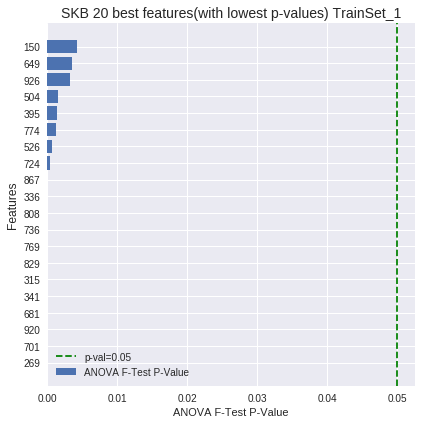

In [24]:
plot_pvalues(SKB_Results_for_all_sets_df[0], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(1))

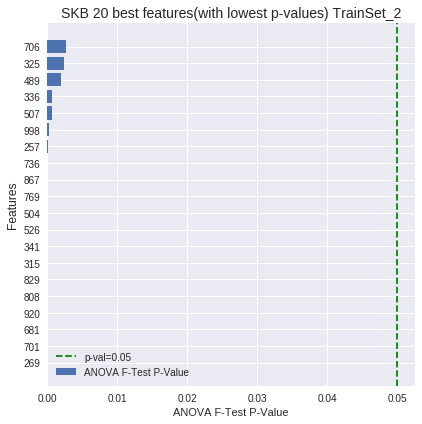

In [25]:
plot_pvalues(SKB_Results_for_all_sets_df[1], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(2))

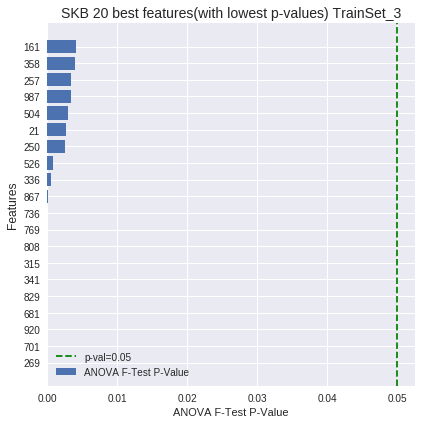

In [26]:
plot_pvalues(SKB_Results_for_all_sets_df[2], 20, 'SKB 20 best features(with lowest p-values) TrainSet_'+str(3))

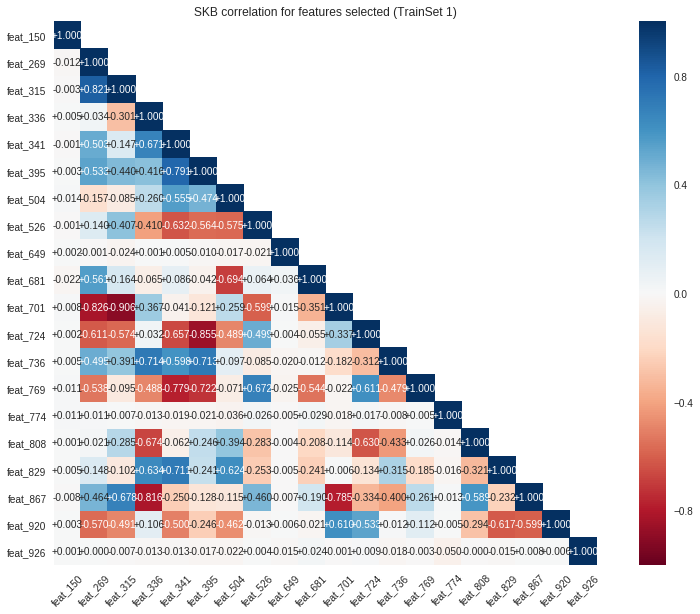

In [27]:
# Plot correlation for dataset 1 features selected.
feats_selected20 = SKB_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected20].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 1)',
          '../data/imgNB2_DB/SKB_corr_img_TS1')

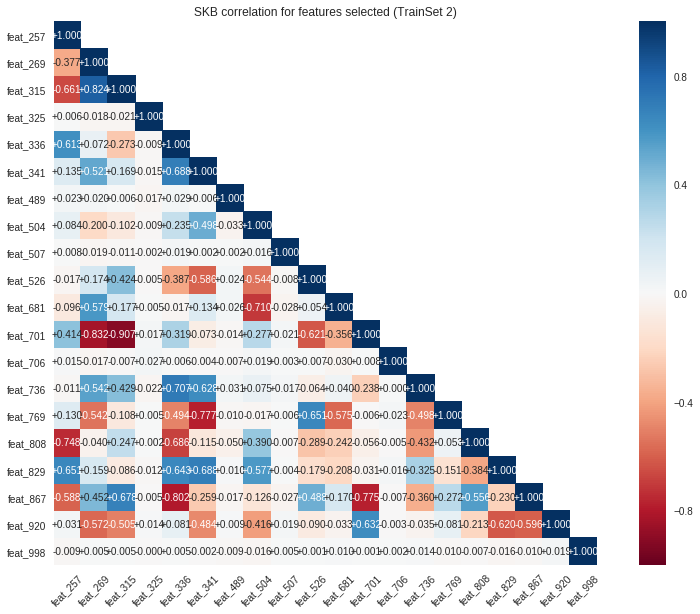

In [28]:
# Plot correlation for dataset 1 features selected.
feats_selected20 = SKB_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected20].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 2)',
          '../data/imgNB2_DB/SKB_corr_img_TS2')

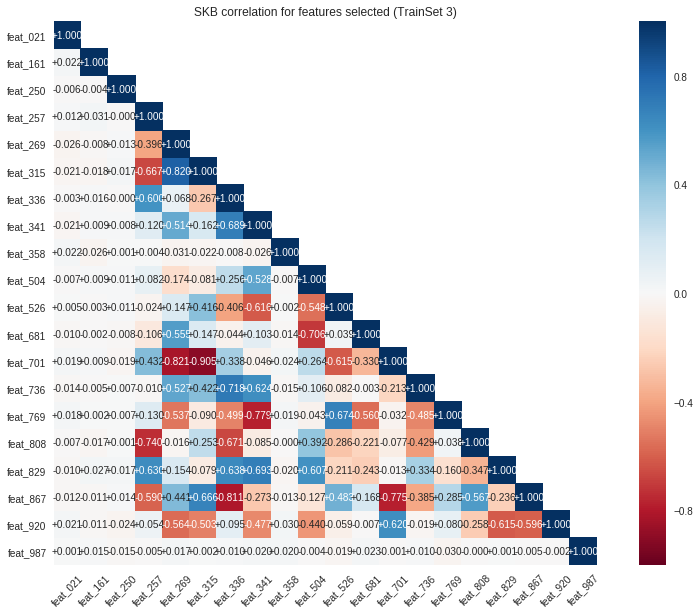

In [29]:
# Plot correlation for dataset 3 features selected.
feats_selected20 = SKB_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected20].corr()
plot_corr(corr, 'SKB correlation for features selected (TrainSet 3)', 
          '../data/imgNB2_DB/SKB_corr_img_TS3')

In [54]:
#*************************************************************************
# FEATURE SELECTION: Use Select Percentile to find the 5% best features.
#                    Since we have 1000, 2% is 20, we know 20 are good.
#
# This method works almost the exact same as SelectKBest, but instead 
# of selecting how many columns you want, you select the percentile. 
# Below, we take the top 2% of columns (i.e. in the top 2% of pvalues). 
# 
#*************************************************************************

In [30]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SP_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1

    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # Taking the top 2% of our p-values.
    selectperc = SelectPercentile(percentile=2)

    # Note he is passing in a scaled version of X_train here.
    selectperc.fit(X_subset_scaled, y_subset)
    
    # Top 10 percentile features selected.
    sp_features = np.where(selectperc.get_support())[0]

    # Let's look at the ANOVA F-test p-values.
    SP_Results_df = write_SP_best_features_to_DF(selectperc, 'SelectPercentile', 'DataSet_'+str(cnt), percent=2)
    
    # Save SP resuts for each training dataset.
    SP_Results_for_all_sets_df.append(SP_Results_df)

In [31]:
SP_Results_for_all_sets_df[0], SP_Results_for_all_sets_df[1], SP_Results_for_all_sets_df[2]

(   feat_select_model  feature      p_values percentile  train_set
 0   SelectPercentile      150  4.293021e-03          2  DataSet_1
 1   SelectPercentile      269  8.366588e-40          2  DataSet_1
 2   SelectPercentile      315  3.692501e-14          2  DataSet_1
 3   SelectPercentile      336  3.097245e-05          2  DataSet_1
 4   SelectPercentile      341  6.974836e-16          2  DataSet_1
 5   SelectPercentile      395  1.416438e-03          2  DataSet_1
 6   SelectPercentile      504  1.489248e-03          2  DataSet_1
 7   SelectPercentile      526  7.649513e-04          2  DataSet_1
 8   SelectPercentile      649  3.516513e-03          2  DataSet_1
 9   SelectPercentile      681  6.014831e-22          2  DataSet_1
 10  SelectPercentile      701  4.461741e-27          2  DataSet_1
 11  SelectPercentile      724  3.802576e-04          2  DataSet_1
 12  SelectPercentile      736  9.937706e-10          2  DataSet_1
 13  SelectPercentile      769  9.954164e-12          2  DataS

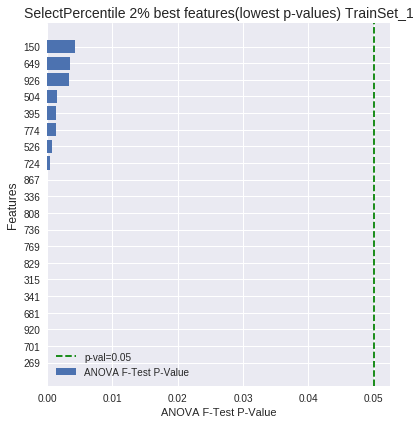

In [32]:
plot_pvalues(SP_Results_for_all_sets_df[0], 20, 'SelectPercentile 2% best features(lowest p-values) TrainSet_'+str(1))

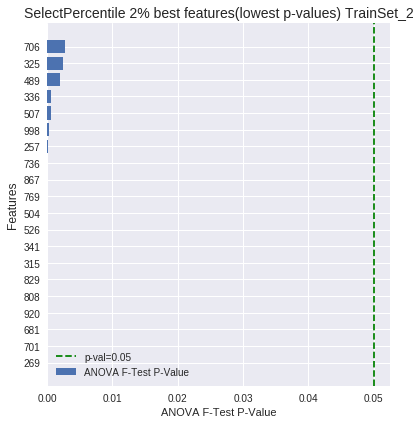

In [33]:
plot_pvalues(SP_Results_for_all_sets_df[1], 20, 'SelectPercentile 2% best features(lowest p-values) TrainSet_'+str(2))

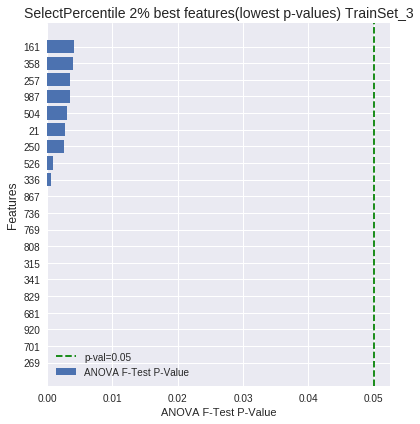

In [34]:
plot_pvalues(SP_Results_for_all_sets_df[2], 20, 'SelectPercentile 2% best features(lowest p-values) TrainSet_'+str(3))

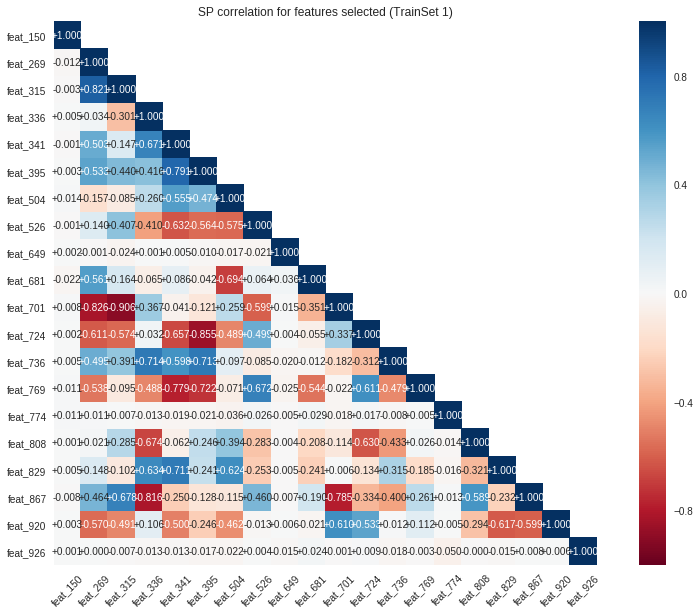

In [35]:
# Plot correlation for dataset 1 features selected.
feats_selected = SP_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 1)',
          '../data/imgNB2_DB/SP_corr_img_TS1')

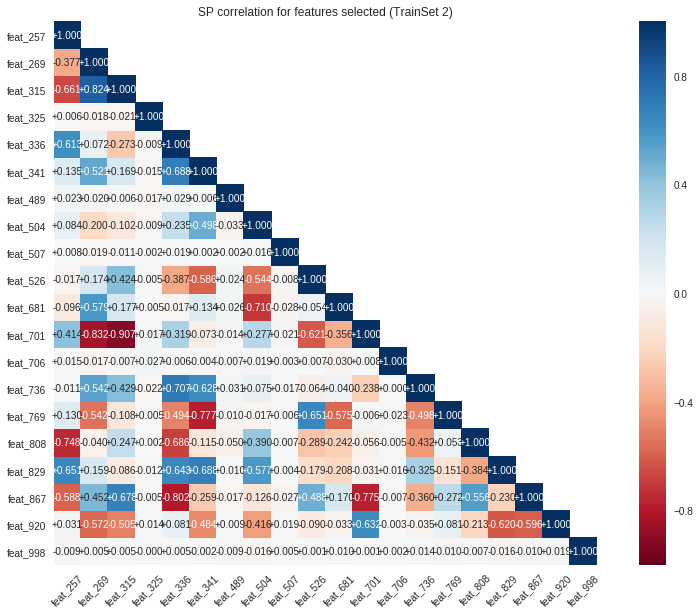

In [36]:
# Plot correlation for dataset 2 features selected.
feats_selected = SP_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 2)', 
          '../data/imgNB2_DB/SP_corr_img_TS2')

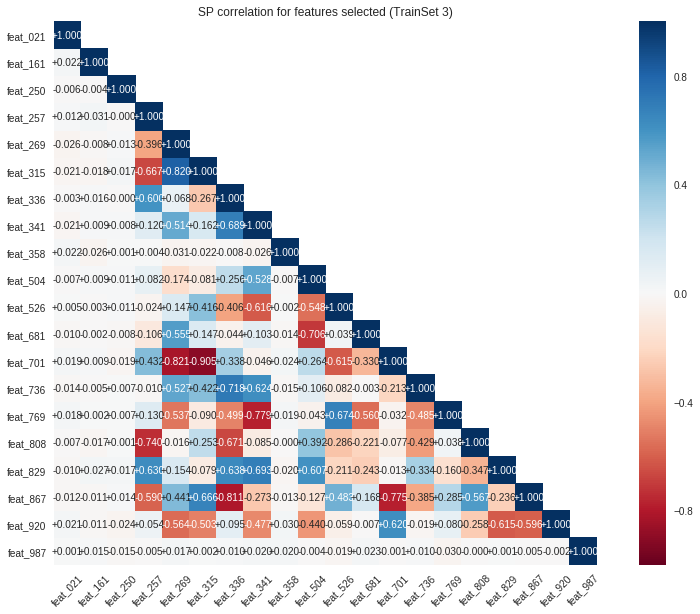

In [37]:
# Plot correlation for dataset 3 features selected.
feats_selected = SP_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'SP correlation for features selected (TrainSet 3)',
          '../data/imgNB2_DB/SP_corr_img_TS3')

In [ ]:
#*************************************************************************
# FEATURE SELECTION: Use Select from model Lasso 
#*************************************************************************

In [38]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SFMlasso_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1

    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # I am using Lasso as the base estimator 
    # since the L1 norm promotes sparsity of features.
    sfm_lasso = SelectFromModel(LassoCV(random_state=42), threshold = 'mean')

    # Note he is passing in a scaled version of X_train here.
    sfm_lasso.fit(X_subset_scaled, y_subset)
    
    # features selected.
    sfm_lasso_feats = np.where(sfm_lasso.get_support())[0]
    
    # Count of features selected.
    lasso_feat_count = len(sfm_lasso_feats)

    # Let's write the results to a dataframe.
    SFMlasso_Results_df = write_SFM_best_features_to_DF(sfm_lasso_feats, 'SFM_Lasso', 
                                                        'DataSet_'+str(cnt), 
                                                        num_feats= lasso_feat_count)
    
    # Save SFM Lasso resuts for each training dataset.
    SFMlasso_Results_for_all_sets_df.append(SFMlasso_Results_df)

In [39]:
SFMlasso_Results_for_all_sets_df[0], SFMlasso_Results_for_all_sets_df[1], SFMlasso_Results_for_all_sets_df[2]

(  feat_select_model  feature  train_set
 0         SFM_Lasso      269  DataSet_1
 1         SFM_Lasso      605  DataSet_1
 2         SFM_Lasso      649  DataSet_1
 3         SFM_Lasso      681  DataSet_1
 4         SFM_Lasso      774  DataSet_1
 5         SFM_Lasso      808  DataSet_1
 6         SFM_Lasso      829  DataSet_1
 7         SFM_Lasso      920  DataSet_1
 8         SFM_Lasso      926  DataSet_1,
    feat_select_model  feature  train_set
 0          SFM_Lasso      133  DataSet_2
 1          SFM_Lasso      143  DataSet_2
 2          SFM_Lasso      154  DataSet_2
 3          SFM_Lasso      195  DataSet_2
 4          SFM_Lasso      269  DataSet_2
 5          SFM_Lasso      279  DataSet_2
 6          SFM_Lasso      325  DataSet_2
 7          SFM_Lasso      489  DataSet_2
 8          SFM_Lasso      507  DataSet_2
 9          SFM_Lasso      544  DataSet_2
 10         SFM_Lasso      621  DataSet_2
 11         SFM_Lasso      677  DataSet_2
 12         SFM_Lasso      681  DataSet_2
 

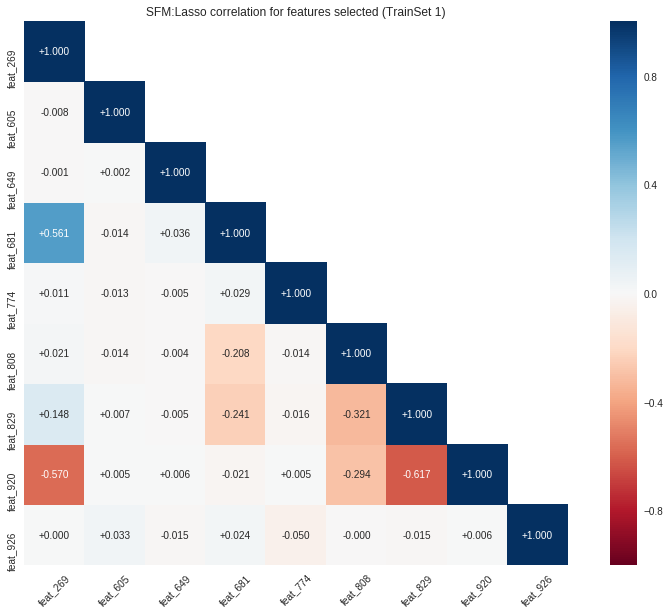

In [40]:
# Plot correlation for dataset 1 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 1)',
          '../data/imgNB2_DB/SFM_Lasso_corr_img_TS1')

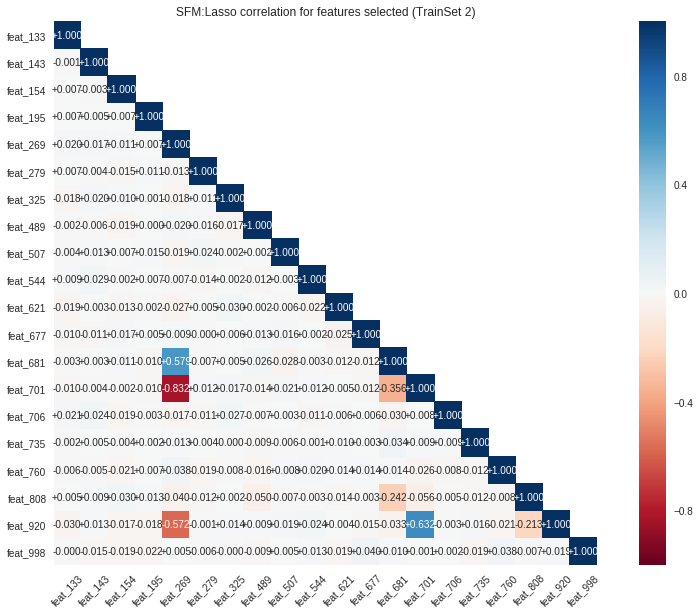

In [41]:
# Plot correlation for dataset 2 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 2)', 
          '../data/imgNB2_DB/SFM_Lasso_corr_img_TS2')

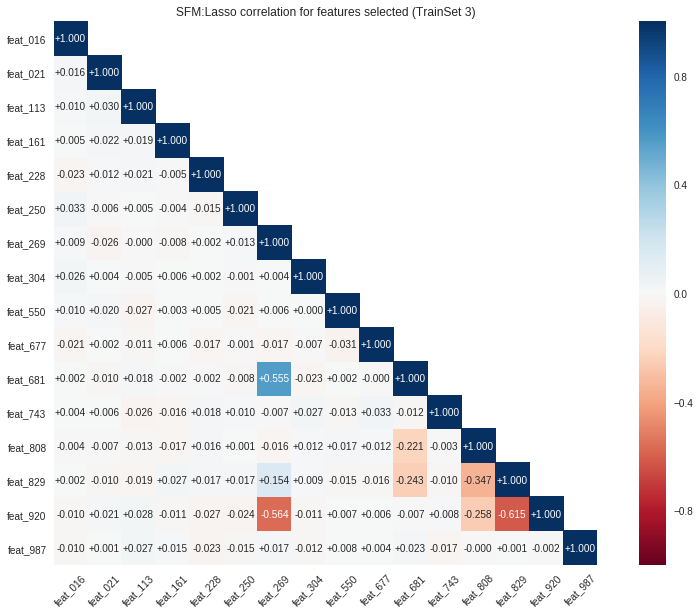

In [42]:
# Plot correlation for dataset 3 features selected.
feats_selected = SFMlasso_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected].corr()
plot_corr(corr, 'SFM:Lasso correlation for features selected (TrainSet 3)', 
          '../data/imgNB2_DB/SFM_Lasso_corr_img_TS3')

In [ ]:
#*************************************************************************
# FEATURE SELECTION: Use Select from model DecisionTreeRegressor
#*************************************************************************

In [43]:
# Zip the X_train_subsets, with the y_trains so we can loop through all subsets.
Xy_data_list = zip(X_train_subsets, y_train_subsets)
cnt=0
SFM_DT_Results_for_all_sets_df = []
for X_subset, y_subset in Xy_data_list:
 
    cnt +=1

    # Inst. SS, transform and scale data. 
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)

    # I am using DEcisionTree as the base estimator 
    sfm_DT = SelectFromModel(DecisionTreeRegressor(random_state=42), threshold = 'mean')

    # Note he is passing in a scaled version of X_train here.
    sfm_DT.fit(X_subset_scaled, y_subset)
    
    # features selected.
    sfm_DT_feats = np.where(sfm_DT.get_support())[0]
    
    # Count of features selected.
    DT_feat_count = len(sfm_DT_feats)

    # Let's write the results to a dataframe.
    SFM_DT_Results_df = write_SFM_best_features_to_DF(sfm_DT_feats, 'SFM_DT', 
                                                      'DataSet_'+str(cnt), 
                                                       num_feats= DT_feat_count)
    
    # Save SFM Lasso resuts for each training dataset.
    SFM_DT_Results_for_all_sets_df.append(SFM_DT_Results_df)
    

In [44]:
SFM_DT_Results_for_all_sets_df[0],SFM_DT_Results_for_all_sets_df[1], SFM_DT_Results_for_all_sets_df[2]

(    feat_select_model  feature  train_set
 0              SFM_DT        1  DataSet_1
 1              SFM_DT       11  DataSet_1
 2              SFM_DT       21  DataSet_1
 3              SFM_DT       24  DataSet_1
 4              SFM_DT       26  DataSet_1
 5              SFM_DT       31  DataSet_1
 6              SFM_DT       35  DataSet_1
 7              SFM_DT       37  DataSet_1
 8              SFM_DT       44  DataSet_1
 9              SFM_DT       51  DataSet_1
 10             SFM_DT       55  DataSet_1
 11             SFM_DT       61  DataSet_1
 12             SFM_DT       67  DataSet_1
 13             SFM_DT       76  DataSet_1
 14             SFM_DT       83  DataSet_1
 15             SFM_DT       84  DataSet_1
 16             SFM_DT       85  DataSet_1
 17             SFM_DT      111  DataSet_1
 18             SFM_DT      118  DataSet_1
 19             SFM_DT      120  DataSet_1
 20             SFM_DT      121  DataSet_1
 21             SFM_DT      128  DataSet_1
 22        

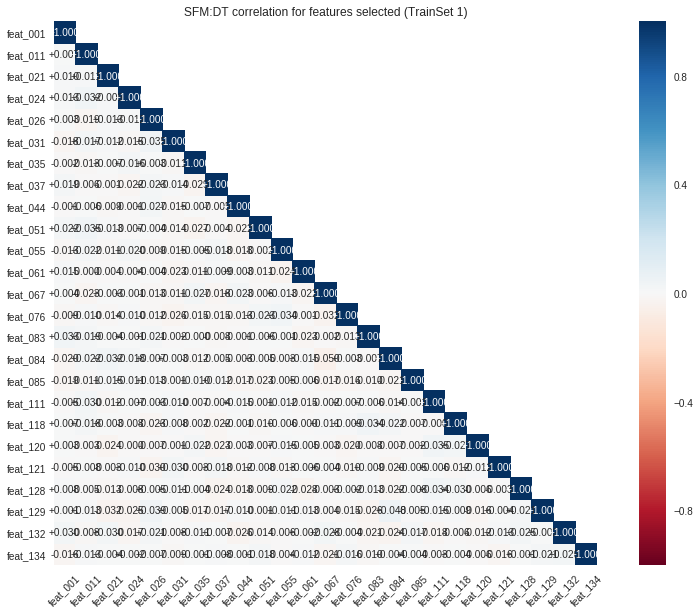

In [45]:
# Plot correlation for dataset 1 features selected.
feats_selected = SFM_DT_Results_for_all_sets_df[0]['feature']
corr = X_train_subsets[0].ix[:,feats_selected[:25]].corr()
plot_corr(corr, 'SFM:DT correlation for features selected (TrainSet 1)', 
          '../data/imgNB2_DB/SFM_DT_corr_img_TS1')

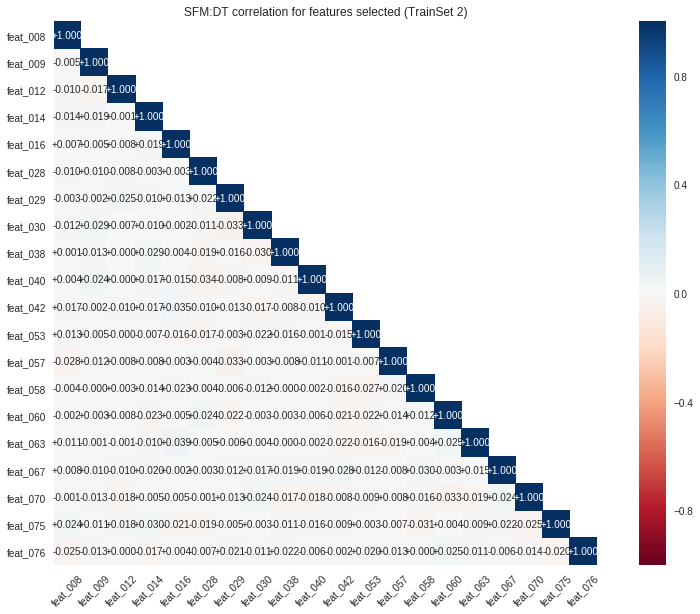

In [46]:
# Plot correlation for dataset 2 features selected.
feats_selected = SFM_DT_Results_for_all_sets_df[1]['feature']
corr = X_train_subsets[1].ix[:,feats_selected[:20]].corr()
plot_corr(corr, 'SFM:DT correlation for features selected (TrainSet 2)',
          '../data/imgNB2/SFM_DT_corr_img_TS2')

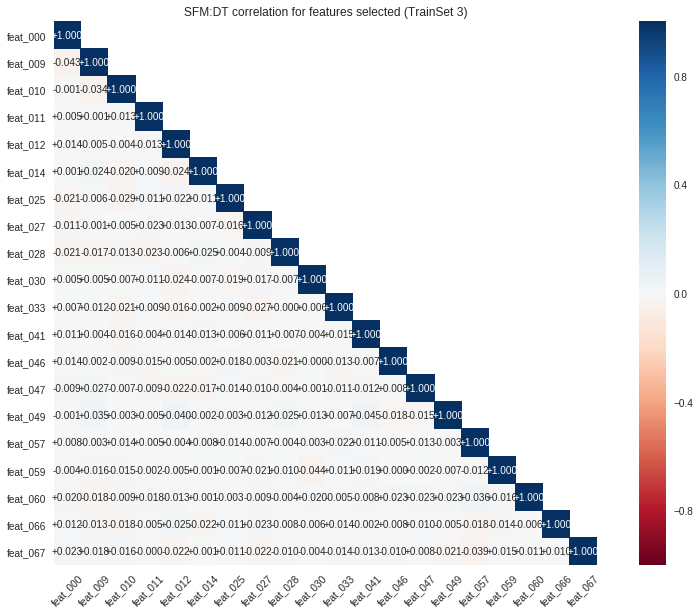

In [47]:
# Plot correlation for dataset 3 features selected.
feats_selected = SFM_DT_Results_for_all_sets_df[2]['feature']
corr = X_train_subsets[2].ix[:,feats_selected[:20]].corr()
plot_corr(corr, 'SFM:DT correlation for features selected (TrainSet 3)', 
          '../data/imgNB2/SFM_DT_corr_img_TS3')

In [48]:
# Pickle the DataFrames for results from the 3 feature selection methods.

SKB_Results_for_all_sets_df[0].to_pickle('../data/dataNB2_DB/SKB_feature_Results_TS1_df.p')
SP_Results_for_all_sets_df[0].to_pickle('../data/dataNB2_DB/SP_feature_Results_TS1_df.p')
SFMlasso_Results_for_all_sets_df[0].to_pickle('../data/dataNB2_DB/Lasso_feature_Results_TS1_df.p')
SFM_DT_Results_for_all_sets_df[0].to_pickle('../data/dataNB2_DB/DT_feature_Results_TS1_df.p')

SKB_Results_for_all_sets_df[1].to_pickle('../data/dataNB2_DB/SKB_feature_Results_TS2_df.p')
SP_Results_for_all_sets_df[1].to_pickle('../data/dataNB2_DB/SP_feature_Results_TS2_df.p')
SFMlasso_Results_for_all_sets_df[1].to_pickle('../data/dataNB2_DB/Lasso_feature_Results_TS2_df.p')
SFM_DT_Results_for_all_sets_df[1].to_pickle('../data/dataNB2_DB/DT_feature_Results_TS2_df.p')

SKB_Results_for_all_sets_df[2].to_pickle('../data/dataNB2_DB/SKB_feature_Results_TS3_df.p')
SP_Results_for_all_sets_df[2].to_pickle('../data/dataNB2_DB/SP_feature_Results_TS3_df.p')
SFMlasso_Results_for_all_sets_df[2].to_pickle('../data/dataNB2_DB/Lasso_feature_Results_TS3_df.p')
SFM_DT_Results_for_all_sets_df[2].to_pickle('../data/dataNB2_DB/DT_feature_Results_TS3_df.p')